In [0]:
# Notebook uploaded on April 30
# Use GPU acceleration
# CONNECT TO GOOGLE DRIVE: Note you need to have EEG folder into MyDrive
from google.colab import drive
drive.mount('/content/gdrive')
!pip install mne==0.20.0

Mounted at /content/gdrive


In [0]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD

import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.regularizers import l1_l2
from tensorflow.keras.layers import TimeDistributed

from sklearn.model_selection import KFold, StratifiedKFold
import mne
from mne.decoding import Scaler
import time, sys, os

Using TensorFlow backend.


In [0]:
tmp_rootdir = '/content/gdrive/My Drive/EEG/'

# path to new data
new_dir = tmp_rootdir + 'New_Epoched_data/'

n = 1
result_dir = tmp_rootdir + 'results/'

# if not os.path.exists(result_dir):
#   !mkdir result_dir
    
# Global variables for training
epochs = 150
Folds = 5

# Use NCHW data format
K.set_image_data_format('channels_first')

In [0]:
Mastoids = ['M1','M2']
EOG_list = ['HEOG', 'VEOG']
n_eeg_channels = 32

subj_list = ['001','002','003','004','005','006','007','008','009','010',
             '011','015','016',
             '021','022','024','025','027','029','030',
             '031','032','033']

n_subj = len(subj_list) 
eeg_chan = []
eeg_chan = eeg_chan + ['A' + str(i+1) for i in range(32)]
chnames = eeg_chan + ['EXG' + str(i+1) for i in range(5)]
blocks = ['can', 'rev']
stimuli = ['standard', 'deviant']

biosemi_layout = mne.channels.read_custom_montage(tmp_rootdir + 'biosemi_cap_32_M_2_EOG_3.locs')
biosemi_layout.ch_names = chnames
event_id = {'Can/Standard':65321,
            'Can/Deviant':65322,
            'Rev/Standard':65341,
            'Rev/Deviant':65342,
            'Can/ExpBeer':65391,
            'Can/ExpPier':65392,
            'Can/Test1':65401,
            'Can/Test2':65402,
            'Rev/ExpBeer':65491,
            'Rev/ExpPier':65492,
            'Rev/Test1':65501,
            'Rev/Test2':65502
            }

In [0]:
# used for resampled data
def get_dat(i):
    subj = subj_list[i]

    fname = resampled_dir+ "%s_resampled_raw.fif" %(subj)
    raw = mne.io.read_raw_fif(resampled_fname, preload = True)
    events = mne.find_events(raw)
    raw.set_eeg_reference('average', projection = True)
    baseline = (-0.2, 0.0)
    epochs = mne.Epochs(raw, events = events, event_id=event_id, 
                      tmin = -0.2, tmax = 0.5, baseline=baseline, preload= True)
    return epochs

def can_train(epochs):
    scaler = mne.decoding.Scaler(info=epochs.info, scalings='mean')
    numEpochs = len(epochs.ch_names)
    beer = epochs['Can/ExpBeer'].crop(-0.2, 0.5)
    pier = epochs['Can/ExpPier'].crop(-0.2, 0.5)
    beer_raw = scaler.fit_transform(beer.get_data())[:, np.arange(numEpochs), :]
    pier_raw = scaler.fit_transform(pier.get_data())[:, np.arange(numEpochs), :]
    X = np.concatenate((beer_raw, pier_raw))
    Y = np.repeat([0,1], [np.shape(beer_raw)[0], np.shape(pier_raw)[0]], axis = 0)
    X=X.reshape(len(X),1,len(X[0]),len(X[0][0]))
    Y = keras.utils.to_categorical(Y, num_classes=2)
    return X,Y

def can_test(epochs):
    scaler = mne.decoding.Scaler(info=epochs.info, scalings='mean')
    numEpochs = len(epochs.ch_names)
    beer = epochs['Can/Test1'].crop(-0.2, 0.5)
    pier = epochs['Can/Test2'].crop(-0.2, 0.5)
    beer_raw = scaler.fit_transform(beer.get_data())[:, np.arange(numEpochs), :]
    pier_raw = scaler.fit_transform(pier.get_data())[:, np.arange(numEpochs), :]
    X = np.concatenate((beer_raw, pier_raw))
    Y = np.repeat([0,1], [np.shape(beer_raw)[0], np.shape(pier_raw)[0]], axis = 0)
    X=X.reshape(len(X),1,len(X[0]),len(X[0][0]))
    Y = keras.utils.to_categorical(Y, num_classes=2)
    return X,Y

def rev_train(epochs):
    scaler = mne.decoding.Scaler(info=epochs.info, scalings='mean')
    numEpochs = len(epochs.ch_names)
    beer = epochs['Rev/ExpBeer'].crop(-0.2, 0.5)
    pier = epochs['Rev/ExpPier'].crop(-0.2, 0.5)
    beer_raw = scaler.fit_transform(beer.get_data())[:, np.arange(numEpochs), :]
    pier_raw = scaler.fit_transform(pier.get_data())[:, np.arange(numEpochs), :]
    X = np.concatenate((beer_raw, pier_raw))
    Y = np.repeat([0,1], [np.shape(beer_raw)[0], np.shape(pier_raw)[0]], axis = 0)
    X=X.reshape(len(X),1,len(X[0]),len(X[0][0]))
    Y = keras.utils.to_categorical(Y, num_classes=2)
    return X,Y


def rev_test(epochs):
    scaler = mne.decoding.Scaler(info=epochs.info, scalings='mean')
    numEpochs = len(epochs.ch_names)
    beer = epochs['Rev/Test1'].crop(-0.2, 0.5)
    pier = epochs['Rev/Test2'].crop(-0.2, 0.5)
    beer_raw = scaler.fit_transform(beer.get_data())[:, np.arange(numEpochs), :]
    pier_raw = scaler.fit_transform(pier.get_data())[:, np.arange(numEpochs), :]
    X = np.concatenate((beer_raw, pier_raw))
    Y = np.repeat([0,1], [np.shape(beer_raw)[0], np.shape(pier_raw)[0]], axis = 0)
    X=X.reshape(len(X),1,len(X[0]),len(X[0][0]))
    Y = keras.utils.to_categorical(Y, num_classes=2)
    return X,Y

### Define Models

In [0]:
# Return CNN model with corresponding number of channels

# Bad?
def run_CNN_new(numChan):
    conv_filters = (1, 5)
    strides = (1, 1)
    pool_size = (1, 3)
    dropoutRate = 0.5
    regRate1 = 0.01
    regRate2 = 0.2
    model = tf.keras.models.Sequential()

    model.add(layers.Conv2D(20, (1, 5), 
                            input_shape=(1, numChan, 91),
                            kernel_constraint = max_norm(.8, axis=(0,1,2))))
    model.add(layers.Conv2D(20, (numChan, 1),
                            kernel_constraint = max_norm(.8, axis=(0,1,2))))
    model.add(layers.BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1))
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    model.add(layers.Dropout(dropoutRate))
  
    model.add(layers.Conv2D(30, (1, 5),
                            kernel_constraint = max_norm(.8, axis=(0,1,2))))
    model.add(layers.BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1))
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    model.add(layers.Dropout(dropoutRate))
    
    model.add(layers.Conv2D(50, (1, 5),
                            kernel_constraint = max_norm(.8, axis=(0,1,2))))
    model.add(layers.BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1))
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    model.add(layers.Dropout(dropoutRate))
    
    model.add(layers.Conv2D(100, (1, 5),
                            kernel_constraint = max_norm(.8, axis=(0,1,2))))
    model.add(layers.BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1))
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))
    model.add(layers.Dropout(dropoutRate))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(2, kernel_constraint = max_norm(0.5)))
    model.add(layers.Activation('softmax'))
    return model

# Pretty Good
def run_DCN(numChan):
    conv_filters = (1, 3)
    strides = (1, 2)
    pool_size = (1, 3)
    dropoutRate = 0.5
    regRate1 = 0.002
    regRate2 = 0.002
    model = tf.keras.models.Sequential()

    model.add(layers.Conv2D(10, (1, 5), input_shape=(1, numChan, 91), padding="same",
                      kernel_regularizer = l1_l2(l1=regRate1, l2=regRate2)))
    model.add(layers.Conv2D(10, (numChan, 1), input_shape=(1, numChan, 91),
                      kernel_regularizer = l1_l2(l1=regRate1, l2=regRate2)))
    model.add(layers.BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1))
    #model.add(tf.keras.layers.LayerNormalization(axis=1 , center=True , scale=True))
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=pool_size, strides=strides))
    model.add(layers.Dropout(dropoutRate))

    model.add(layers.Conv2D(50, conv_filters,
                          kernel_regularizer = l1_l2(l1=regRate1, l2=regRate2)))
    model.add(layers.BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1))
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=pool_size, strides=strides))
    model.add(layers.Dropout(dropoutRate))

    model.add(layers.Conv2D(80, conv_filters,
                          kernel_regularizer = l1_l2(l1=regRate1, l2=regRate2)))
    model.add(layers.BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1))
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=pool_size, strides=strides))
    model.add(layers.Dropout(dropoutRate))

    model.add(layers.Conv2D(100, conv_filters,
                            kernel_regularizer = l1_l2(l1=regRate1, l2=regRate2)))
    model.add(layers.BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1))
    model.add(layers.Activation('elu'))
    model.add(layers.AveragePooling2D(pool_size=(1,2), strides=strides))
    model.add(layers.Dropout(dropoutRate))

    model.add(layers.Flatten())
    model.add(layers.Dense(2))
    model.add(layers.Activation('softmax'))
    #adam = optimizers.Adam(learning_rate=0.00001)
    #sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)


    return model

def run_SCN(numChan):
    conv_filters = (1, 15)
    strides = (1, 7)
    pool_size = (1, 35)
    dropoutRate = 0.25
    regRate = 0.0001
    model = tf.keras.models.Sequential()
    #model.add(layers.Conv2D(40, (1, 10), input_shape=(1, numChan, 91)))

    model.add(layers.Conv2D(40, (numChan, 25), input_shape=(1, numChan, 91),padding="same",
                          kernel_regularizer = l1_l2(l1=regRate, l2=regRate)))
    model.add(layers.BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1))
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=(1,75), strides=strides))
    model.add(layers.Dropout(dropoutRate))
    model.add(layers.Flatten())
    model.add(layers.Dense(2))
    model.add(layers.Activation('softmax'))

    return model

# Still cannot be implemented
def run_LSTMCNN(numChan):
    conv_filters = (1, 3)
    strides = (1, 12)
    pool_size = (1, 63)
    dropoutRate = 0.5
    regRate1 = 0.001
    regRate2 = 0.001
    model = tf.keras.models.Sequential()

    model.add(TimeDistributed(layers.Conv2D(40, (1, 25), padding="same",
                      kernel_regularizer = l1_l2(l1=regRate1, l2=regRate2)), input_shape=(None, 1, numChan, 91)))
    model.add(TimeDistributed(layers.Conv2D(40, (numChan, 1), input_shape=(1, numChan, 91),
                      kernel_regularizer = l1_l2(l1=regRate1, l2=regRate2))))
    model.add(TimeDistributed(layers.BatchNormalization(axis=1, epsilon=1e-05, momentum=0.5)))
    #model.add(tf.keras.layers.LayerNormalization(axis=1 , center=True , scale=True))
    model.add(TimeDistributed(layers.Activation('elu')))
    model.add(TimeDistributed(layers.MaxPooling2D(pool_size=pool_size, strides=strides)))
    model.add(TimeDistributed(layers.Dropout(dropoutRate)))

#     model.add(TimeDistributed(layers.Conv2D(50, conv_filters,
#                           kernel_regularizer = l1_l2(l1=regRate1, l2=regRate2))))
#     model.add(TimeDistributed(layers.BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)))
#     model.add(TimeDistributed(layers.Activation('elu')))
#     model.add(TimeDistributed(layers.MaxPooling2D(pool_size=pool_size, strides=strides)))
#     model.add(TimeDistributed(layers.Dropout(dropoutRate)))

#     model.add(TimeDistributed(layers.Conv2D(80, conv_filters,
#                           kernel_regularizer = l1_l2(l1=regRate1, l2=regRate2))))
#     model.add(TimeDistributed(layers.BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)))
#     model.add(TimeDistributed(layers.Activation('elu')))
#     model.add(TimeDistributed(layers.MaxPooling2D(pool_size=pool_size, strides=strides)))
#     model.add(TimeDistributed(layers.Dropout(dropoutRate)))

#     model.add(TimeDistributed(layers.Conv2D(100, conv_filters,
#                           kernel_regularizer = l1_l2(l1=regRate1, l2=regRate2))))
#     model.add(TimeDistributed(layers.BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)))
#     model.add(TimeDistributed(layers.Activation('elu')))
#     model.add(TimeDistributed(layers.MaxPooling2D(pool_size=pool_size, strides=strides)))
#     model.add(TimeDistributed(layers.Dropout(dropoutRate)))

    model.add(TimeDistributed(layers.Flatten()))
    
    # define LSTM model
    model.add(layers.LSTM(50, return_sequences=True, kernel_regularizer = l1_l2(l1=regRate1, l2=regRate2)))
    model.add(layers.Dense(2))
    model.add(layers.Activation("softmax"))
    return model

### Display a sample CNN model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 32, 91)        60        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 1, 91)         3210      
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 1, 91)         40        
_________________________________________________________________
activation (Activation)      (None, 10, 1, 91)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 1, 45)         0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 1, 45)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 1, 43)         1

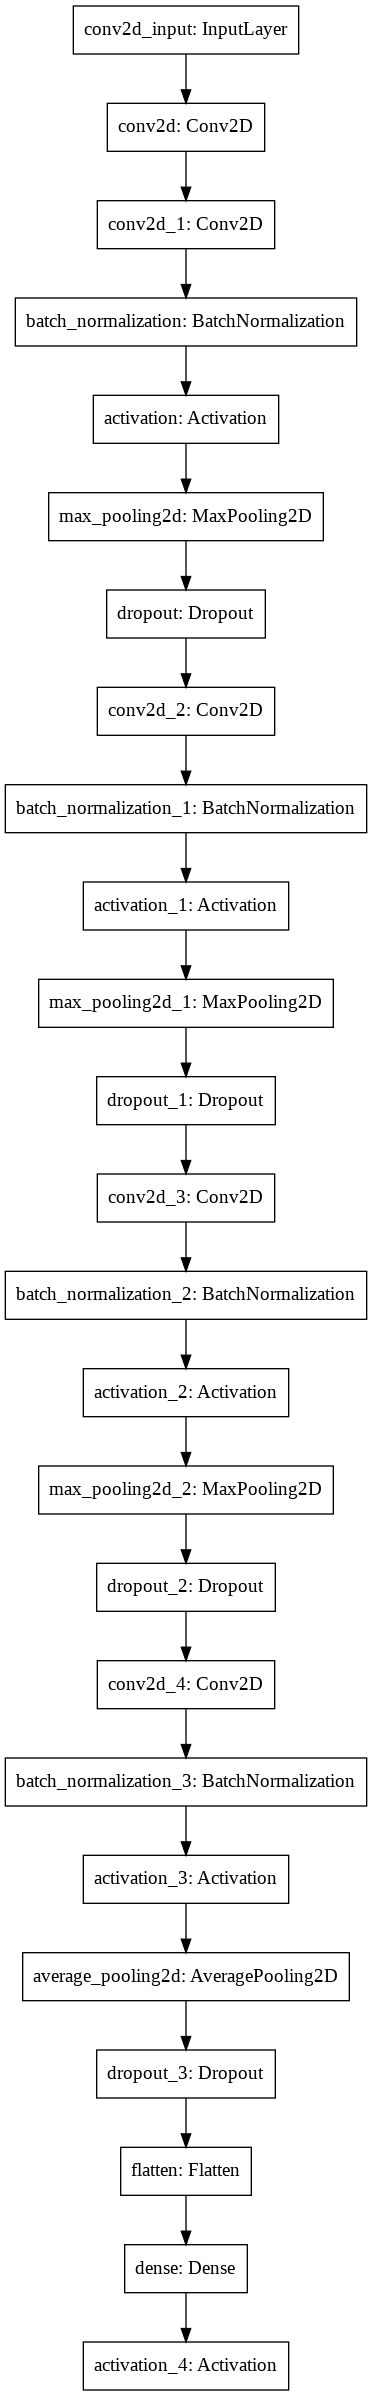

In [0]:
K.set_image_data_format('channels_first')
K.clear_session()

sample_CNN = run_DCN(32)
sample_CNN.summary()
from tensorflow.keras.utils import plot_model
plot_model(sample_CNN, to_file = result_dir + 'model.png')

In [0]:
def train_subject(subj, event):
    Folds = 5
    kf = KFold(n_splits=Folds, shuffle=True)
    epochs = 150
    epoch1 = mne.read_epochs(new_dir + '%s_epoch_M.fif' %subj_list[subj])
    if event == "can":
        X,  Y = can_test(epoch1)
    elif event == "rev":
        X,  Y = rev_test(epoch1)
    train_avg_loss = np.zeros(epochs)
    train_avg_accuracy = np.zeros(epochs)
    valid_avg_loss = np.zeros(epochs)
    valid_avg_accuracy = np.zeros(epochs)
    CV = np.zeros(Folds)
    # K-Fold Cross-Validation
    k = 0
    for train_index, test_index in kf.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        model = run_DCN(len(epoch1.ch_names))
        adam = tf.keras.optimizers.Adam(learning_rate=0.0015)
        model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
        CV_history = model.fit(X_train, y_train, epochs=epochs, 
                               validation_data=(X_test, y_test))
        train_avg_loss += CV_history.history['loss']
        train_avg_accuracy += CV_history.history['accuracy']
        valid_avg_loss += CV_history.history['val_loss']
        valid_avg_accuracy += CV_history.history['val_accuracy']        
        # cross-validation error at fold k for subject i
        CV[k] = CV_history.history['val_accuracy'][-1]
        k += 1

    return train_avg_loss/(Folds), train_avg_accuracy/(Folds), valid_avg_loss/(Folds), valid_avg_accuracy/(Folds), CV

### Start training and validating on Canonical data

In [0]:
%%capture
# Train and tune on canoncal data 
# It takes around 6 min to run ...
import datetime
epochs = 150
train_loss_can = np.zeros((len(subj_list), epochs))
train_accuracy_can = np.zeros((len(subj_list), epochs))
valid_loss_can = np.zeros((len(subj_list), epochs))
valid_accuracy_can = np.zeros((len(subj_list), epochs))
CV_can = np.zeros((len(subj_list), Folds))
start_time = time.time()
Folds = 5
kf = KFold(n_splits=Folds, shuffle=True)

for i in range(len(subj_list)):
    train_avg_loss, train_avg_accuracy, valid_avg_loss, valid_avg_accuracy, CV = train_subject(i, "can")
    train_loss_can[i] = train_avg_loss
    train_accuracy_can[i] = train_avg_accuracy
    valid_loss_can[i] = valid_avg_loss
    valid_accuracy_can[i] = valid_avg_accuracy
    CV_can[i] = CV
    
    K.clear_session()

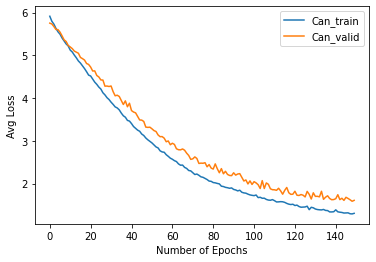

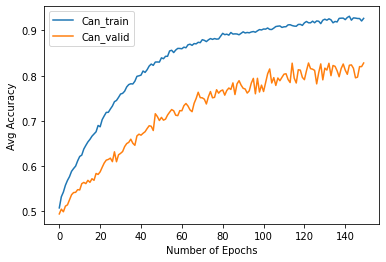

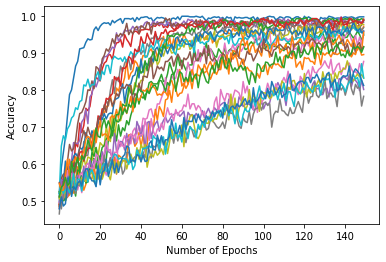

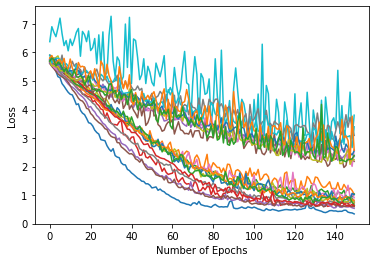

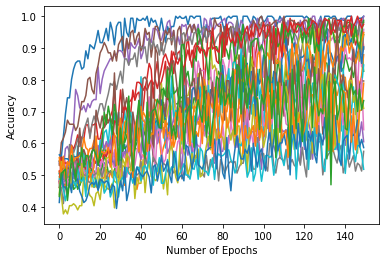

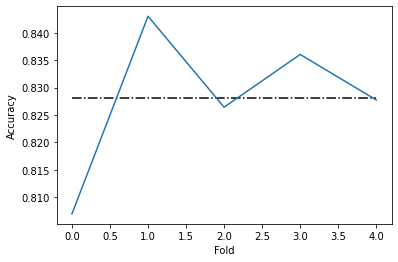

In [0]:
# Average loss with respect to number of epochs
plt.plot(np.arange(epochs), np.mean(train_loss_can, axis=0))
plt.plot(np.arange(epochs), np.nanmean(valid_loss_can, axis=0))
plt.xlabel('Number of Epochs')
plt.ylabel('Avg Loss')
plt.legend(['Can_train', 'Can_valid'])
plt.savefig(result_dir + "Can_loss.png", dpi=300)
plt.show()

# Average accuracy with respect to number of epochs
plt.plot(np.arange(epochs), np.mean(train_accuracy_can, axis=0))
plt.plot(np.arange(epochs), np.mean(valid_accuracy_can, axis=0))
plt.xlabel('Number of Epochs')
plt.ylabel('Avg Accuracy')
plt.legend(['Can_train', 'Can_valid'])
plt.savefig(result_dir + "Can_accuracy.png", dpi=300)
plt.show()

# Training accuracy with respect to number of epochs, for each subject
for i in range(len(subj_list)):
    plt.plot(np.arange(epochs), train_accuracy_can[i])
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
#plt.legend(subj_list)
plt.savefig(result_dir + "Can_train_loss.png", dpi=300)
plt.show()

# Validation loss with respect to number of epochs, for each subject
for i in range(len(subj_list)):
    plt.plot(np.arange(epochs), valid_loss_can[i])
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
#plt.legend(subj_list)
plt.savefig(result_dir + "Can_train_accuracy.png", dpi=300)
plt.show()

# Validation accuracy with respect to number of epochs, for each subject
for i in range(len(subj_list)):
    plt.plot(np.arange(epochs), valid_accuracy_can[i])
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
#plt.legend(subj_list)
plt.savefig(result_dir + "Can_valid_loss.png", dpi=300)
plt.show()

# K Fold cross validation accuracy
plt.plot(np.arange(Folds), np.mean(CV_can, axis=0))
plt.hlines(y = np.mean(CV_can), xmin=0, xmax=Folds-1, linestyles='dashdot')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
#plt.legend(subj_list)
plt.show()

Training took 17.74 Min


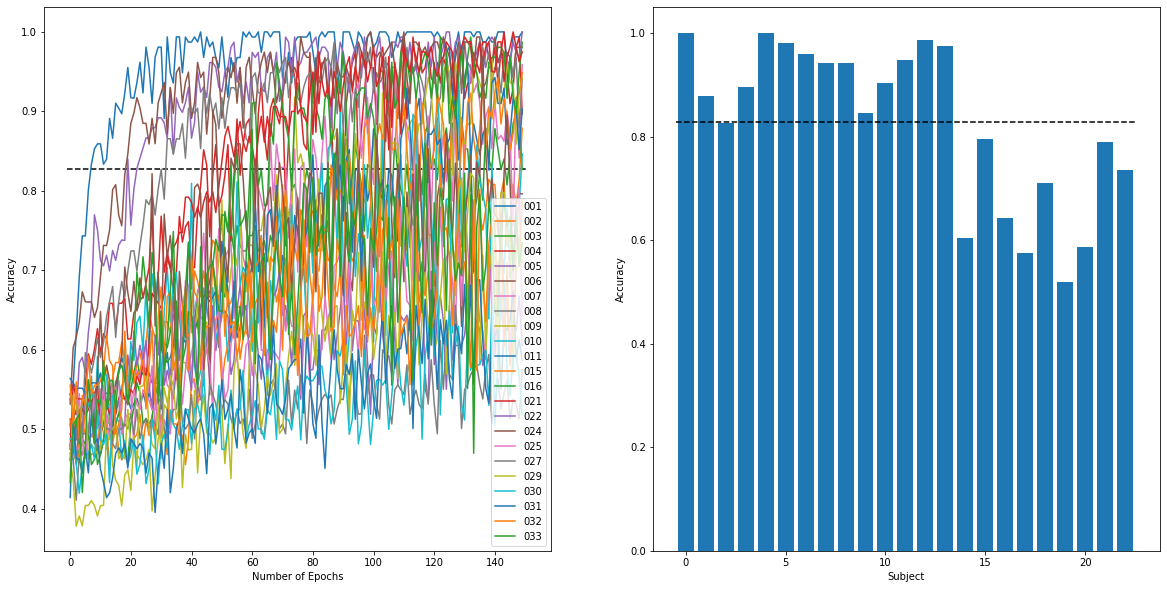

In [0]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

for i in range(len(subj_list)):
    ax1.plot(np.arange(epochs), valid_accuracy_can[i])
ax1.hlines(y = np.mean(valid_accuracy_can.T[-1]), linestyles="dashed", xmin = -1, xmax = epochs+1)
ax1.set_xlabel('Number of Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(subj_list, loc = 4)

ax2.bar(np.arange(len(subj_list)), np.mean(CV_can, axis=1))
ax2.hlines(y = np.mean(np.mean(CV_can, axis=1)), linestyles="dashed", xmin = -0.5, xmax = len(subj_list)-0.4)
ax2.set_xlabel('Subject')
ax2.set_ylabel('Accuracy')

elapsed_time = (time.time()-start_time)/60
print("Training took", round(elapsed_time, 2), "Min")
fig.savefig(result_dir + "Can_CV.png", dpi=300)
plt.show()
plt.close()

### train and validate on Reverse data

In [0]:
%%capture
train_loss_rev = np.zeros((len(subj_list), epochs))
train_accuracy_rev = np.zeros((len(subj_list), epochs))
valid_loss_rev = np.zeros((len(subj_list), epochs))
valid_accuracy_rev = np.zeros((len(subj_list), epochs))
CV_rev = np.zeros((len(subj_list), Folds))
Folds = 5
kf = KFold(n_splits=Folds, shuffle=True)
epochs = 150

for i in range(len(subj_list)):
    train_avg_loss, train_avg_accuracy, valid_avg_loss, valid_avg_accuracy, CV = train_subject(i, "rev")
    train_loss_rev[i] = train_avg_loss
    train_accuracy_rev[i] = train_avg_accuracy
    valid_loss_rev[i] = valid_avg_loss
    valid_accuracy_rev[i] = valid_avg_accuracy
    CV_rev[i] = CV
    
    K.clear_session()

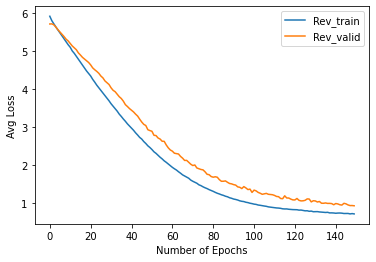

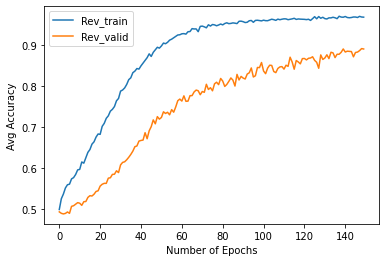

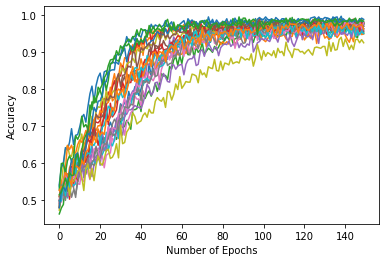

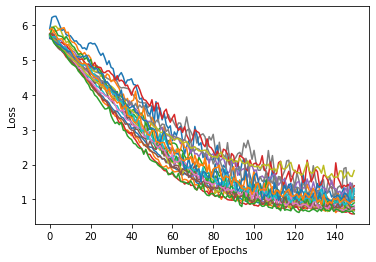

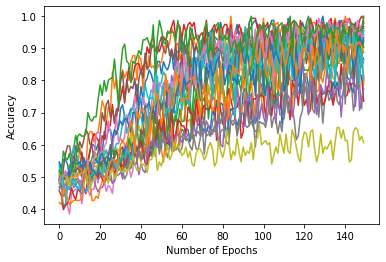

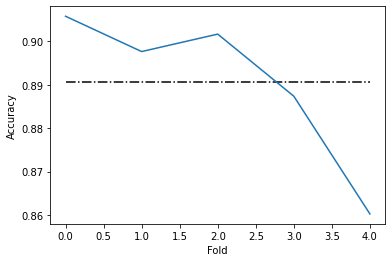

In [0]:
# Average loss with respect to number of epochs
plt.plot(np.arange(epochs), np.mean(train_loss_rev, axis=0))
plt.plot(np.arange(epochs), np.nanmean(valid_loss_rev, axis=0))
plt.xlabel('Number of Epochs')
plt.ylabel('Avg Loss')
plt.legend(['Rev_train', 'Rev_valid'])
plt.savefig(result_dir + "Rev_loss.png", dpi=300)
plt.show()

# Average accuracy with respect to number of epochs
plt.plot(np.arange(epochs), np.mean(train_accuracy_rev, axis=0))
plt.plot(np.arange(epochs), np.mean(valid_accuracy_rev, axis=0))
plt.xlabel('Number of Epochs')
plt.ylabel('Avg Accuracy')
plt.legend(['Rev_train', 'Rev_valid'])
plt.savefig(result_dir + "Rev_accuracy.png", dpi=300)
plt.show()

# Training accuracy with respect to number of epochs, for each subject
for i in range(len(subj_list)):
    plt.plot(np.arange(epochs), train_accuracy_rev[i])
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
#plt.legend(subj_list)
plt.savefig(result_dir + "Rev_train_accuracy.png", dpi=300)
plt.show()

# Validation loss with respect to number of epochs, for each subject
for i in range(len(subj_list)):
    plt.plot(np.arange(epochs), valid_loss_rev[i])
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
#plt.legend(subj_list)
plt.savefig(result_dir + "Rev_valid_loss.png", dpi=300)
plt.show()

# Validation accuracy with respect to number of epochs, for each subject
for i in range(len(subj_list)):
    plt.plot(np.arange(epochs), valid_accuracy_rev[i])
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
#plt.legend(subj_list)
plt.savefig(result_dir + "Rev_valid_accuracy.png", dpi=300)
plt.show()

# K Fold cross validation accuracy
plt.plot(np.arange(Folds), np.mean(CV_rev, axis=0))
plt.hlines(y = np.mean(CV_rev), xmin=0, xmax=Folds-1, linestyles='dashdot')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
#plt.legend(subj_list)
plt.show()

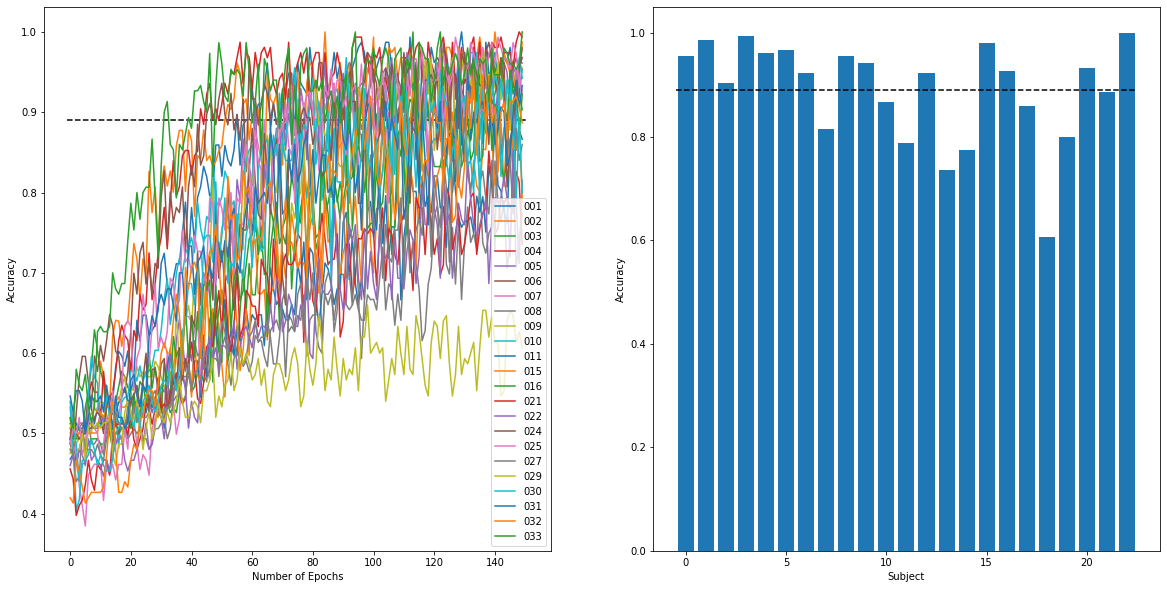

In [0]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

for i in range(len(subj_list)):
    ax1.plot(np.arange(epochs), valid_accuracy_rev[i])
ax1.hlines(y = np.mean(valid_accuracy_rev.T[-1]), linestyles="dashed", xmin = -1, xmax = epochs+1)
ax1.set_xlabel('Number of Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(subj_list, loc = 4)

ax2.bar(np.arange(len(subj_list)),np.mean(CV_rev, axis=1))
ax2.hlines(y = np.mean(np.mean(CV_rev, axis=1)), linestyles="dashed", xmin = -0.5, xmax = len(subj_list)-0.5)
ax2.set_xlabel('Subject')
ax2.set_ylabel('Accuracy')
fig.savefig(result_dir + "Rev_CV.png", dpi=300)

## Save results in datafram

In [0]:
import pandas as pd

In [0]:
# save Can results
train_loss_can_df = pd.DataFrame(train_loss_can, columns = [i for i in range(1,epochs+1)], index = subj_list)
train_accuracy_can_df = pd.DataFrame(train_accuracy_can, columns = [i for i in range(1,epochs+1)], index = subj_list)
valid_loss_can_df = pd.DataFrame(valid_loss_can, columns = [i for i in range(1,epochs+1)], index = subj_list)
valid_accuracy_can_df = pd.DataFrame(valid_accuracy_can, columns = [i for i in range(1,epochs+1)], index = subj_list)
CV_can_df = pd.DataFrame(CV_can, columns = [i for i in range(1,Folds+1)], index = subj_list)

# save Rev results
train_loss_rev_df = pd.DataFrame(train_loss_rev, columns = [i for i in range(1,epochs+1)], index = subj_list)
train_accuracy_rev_df = pd.DataFrame(train_accuracy_rev, columns = [i for i in range(1,epochs+1)], index = subj_list)
valid_loss_rev_df = pd.DataFrame(valid_loss_rev, columns = [i for i in range(1,epochs+1)], index = subj_list)
valid_accuracy_rev_df = pd.DataFrame(valid_accuracy_rev, columns = [i for i in range(1,epochs+1)], index = subj_list)
CV_rev_df = pd.DataFrame(CV_rev, columns = [i for i in range(1,Folds+1)], index = subj_list)

In [0]:
train_loss_can_df.to_csv(result_dir + 'train_loss_can.csv')
train_accuracy_can_df.to_csv(result_dir + 'train_accuracy_can.csv')
valid_loss_can_df.to_csv(result_dir + 'valid_loss_can.csv')
valid_accuracy_can_df.to_csv(result_dir + 'valid_accuracy_can.csv')
CV_can_df.to_csv(result_dir + 'CV_can.csv')

train_loss_rev_df.to_csv(result_dir + 'train_loss_rev.csv')
train_accuracy_rev_df.to_csv(result_dir + 'train_accuracy_rev.csv')
valid_loss_rev_df.to_csv(result_dir + 'valid_loss_rev.csv')
valid_accuracy_rev_df.to_csv(result_dir + 'valid_accuracy_rev.csv')
CV_rev_df.to_csv(result_dir + 'CV_rev.csv')

In [0]:
elapsed_time = (time.time() - start_time)/60
print("All tasks took", round(elapsed_time, 2), "Min")

All tasks took 34.35 Min


In [0]:
K.clear_session()

### Analysis